<a href="https://colab.research.google.com/github/aadmberrada/WalmartSales/blob/main/DTS_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Import

In [1]:
pip install catboost

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', 100)
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import time
import xgboost
from xgboost import XGBRegressor 
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import re



In [3]:
PATH = "/content/drive/MyDrive/DTS/walmart-recruiting-store-sales-forecasting"

train = pd.read_csv(PATH+ "/train.csv")
features = pd.read_csv(PATH+ "/features.csv")
stores = pd.read_csv(PATH+ "/stores.csv")

In [4]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

# 1 - Présentation des jeux de données

In [5]:
train = train.drop("IsHoliday", axis = 1)
train.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90


In [6]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
df = pd.merge(left = train, right = features ,on = ['Date', "Store"], how = 'inner')
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [8]:
#df.to_csv(PATH + '/bdd_merged.csv')

# 3 - Features Engineering

## 3 - 1 - Décomposition du Timestamp

In [9]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df['year'] = df["Date"].dt.year
df['month'] = df["Date"].dt.month
df['day'] = df["Date"].dt.day
df['week'] = df["Date"].dt.week

## 3 - 2 - Création des endogènes retardées

In [10]:
# Création de 6 lags

for lag in list(range(4, 25, 4)):
    df['Weekly_Sales_'+str(lag)] = df.groupby(
        ['Store',	'Dept'], 
        as_index = False)['Weekly_Sales'].shift(lag).astype(np.float64)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,year,month,day,week,Weekly_Sales_4,Weekly_Sales_8,Weekly_Sales_12,Weekly_Sales_16,Weekly_Sales_20,Weekly_Sales_24
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN


## 3 - 3 - Agrégations

In [11]:
df['Store_sales_avg'] = df.groupby('Store')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Dept_sales_avg'] = df.groupby('Dept')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Store_Dept_sales_avg'] = df.groupby(['Store','Dept'])['Weekly_Sales'].transform('mean').astype(np.float64)

df = df.replace(np.inf, np.nan)

## 3 - 4 - Création des variables relatives aux fêtes

In [12]:
df['Super_Bowl']   =  np.where(((df['Date'] == "2010-02-10") | (df['Date'] == "2011-02-11") | 
                                (df['Date'] == "2012-02-10") | (df['Date'] == "2013-02-08")), 1, 0)

df['Labor_day']    =  np.where(((df['Date'] == "2010-09-10") | (df['Date'] == "2011-09-09") | 
                                (df['Date'] == "2012-09-07") | (df['Date'] == "2013-09-06")), 1, 0)

df['Thanksgiving'] =  np.where(((df['Date'] == "2010-11-26") | (df['Date'] == "2011-11-25") | 
                                (df['Date'] == "2012-11-23") | (df['Date'] == "2013-11-29")), 1, 0)

df['Christmas']    =  np.where(((df['Date'] == "2010-12-31") | (df['Date'] == "2011-12-30") | 
                                (df['Date'] == "2012-12-28") | (df['Date'] ==  "2013-12-27")),1, 0)

In [13]:
df["Benefice"] = np.where(df["Weekly_Sales"]>0, 1, 0)

df["Benefice"].value_counts()

1    420212
0      1358
Name: Benefice, dtype: int64

# 4 - Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

## 4 - 1 - Répartition par année des observations

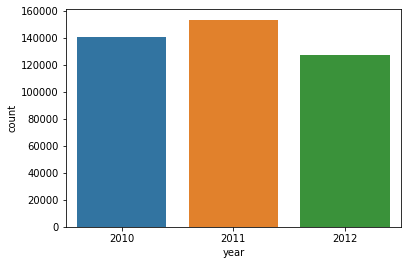

In [ ]:
sns.countplot(df['year'])

Ce résultat ne nous surprend pas car les observations commencent en Février 2010 et se terminent en Novembre 2012. Ce qui fait qu'on n'a que l'année 2011 qui est complète.

## 4 - 2 - Moyenne mensuelle des ventes 

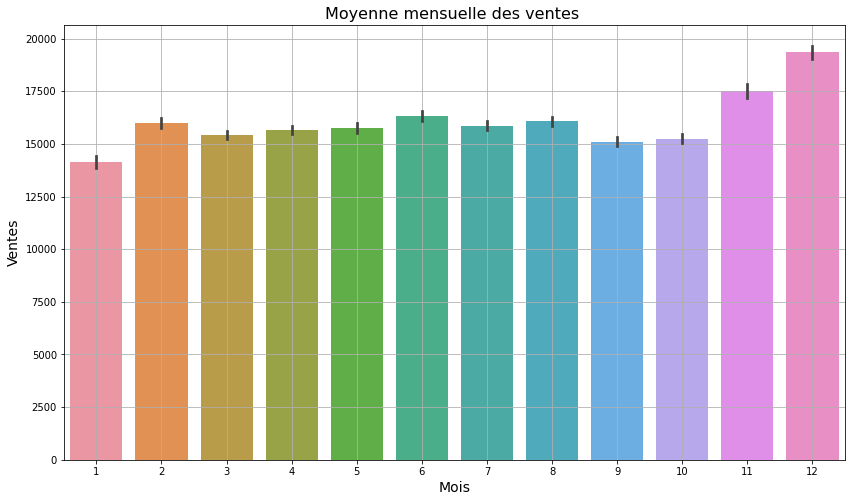

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(x='month',y='Weekly_Sales',data=df)
plt.ylabel('Ventes',fontsize=14)
plt.xlabel('Mois',fontsize=14)
plt.title('Moyenne mensuelle des ventes ',fontsize=16)

Le niveau des ventes est presque homogène d'un mois à un autre mais on remarque des mois qui sont plus marqués que d'autres comme notamment grâce ax fêtes. Il s'agit de Décembre avec Noël, Novembre et Thanksgiving, Févier avec le Superboal.

## 4 - 3 - Ventes Moyennes par store

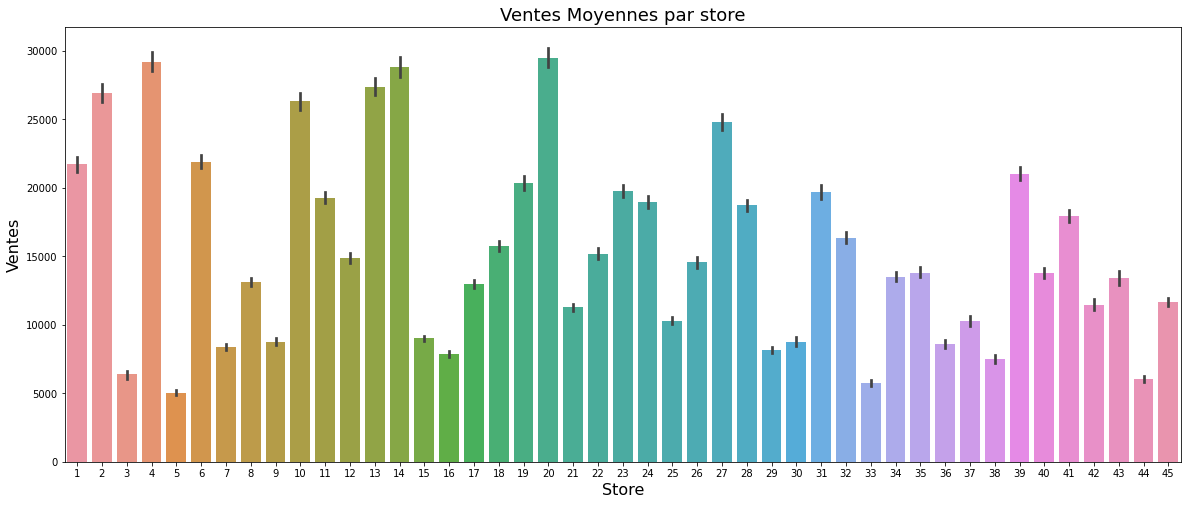

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='Store',y='Weekly_Sales',data=df)
plt.title('Ventes Moyennes par store', fontsize=18)
plt.ylabel('Ventes', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

On voit bien qu'il y a des stores plus importants que d'autres en termes de vente , il vaut mieux miser sur les top stores tels que store 20, 14, 13, 10, 4, 2 et 27

## 4 - 4 - Ventes Moyennes par rayon

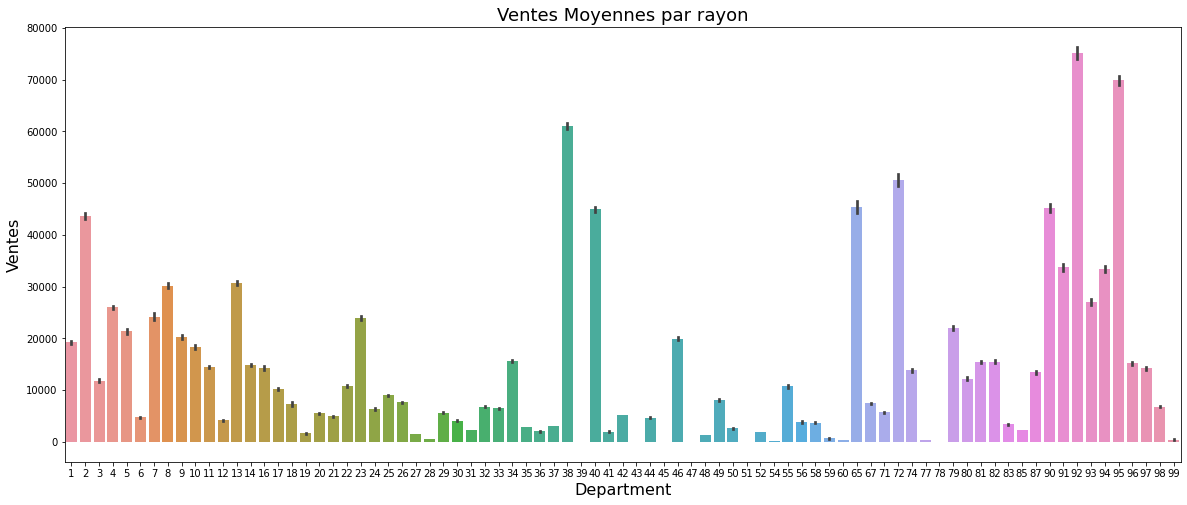

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='Dept',y='Weekly_Sales',data=df)
plt.title('Ventes Moyennes par rayon', fontsize=18)
plt.ylabel('Ventes', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.show()

Il est intéressant de cibler quelques rayons clés ou les ventes explosent tels que le 92, 95, 38, 72, 40, 65 et le 90.

## 4 - 5 - Moyenne des ventes par année

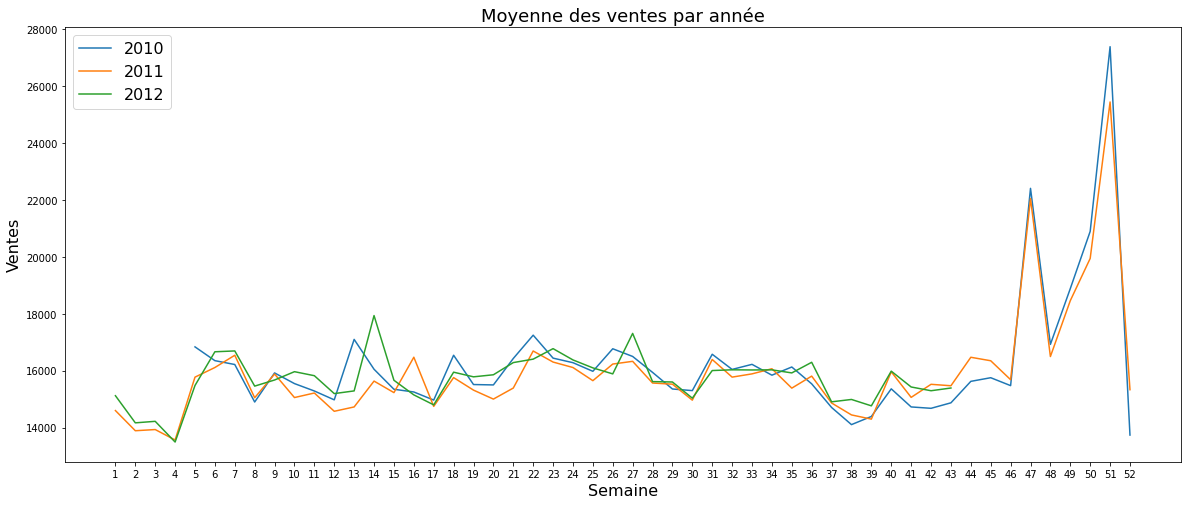

In [ ]:
weekly_sales_2010 = df[df.year==2010]['Weekly_Sales'].groupby(df['week']).mean()
weekly_sales_2011 = df[df.year==2011]['Weekly_Sales'].groupby(df['week']).mean()
weekly_sales_2012 = df[df.year==2012]['Weekly_Sales'].groupby(df['week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Moyenne des ventes par année', fontsize=18)
plt.ylabel('Ventes', fontsize=16)
plt.xlabel('Semaine', fontsize=16)
plt.show()

On voit les rendances se confirment sur les 2 années, on a les mêmes pics au niveau des semaines coincidant à à des fêtes.

# 5 - Data Cleaning

In [14]:
(df.isna().sum()/df.shape[0]).sort_values(ascending = False)

MarkDown2               0.736110
MarkDown4               0.679847
MarkDown3               0.674808
MarkDown1               0.642572
MarkDown5               0.640790
Weekly_Sales_24         0.179795
Weekly_Sales_20         0.150623
Weekly_Sales_16         0.121237
Weekly_Sales_12         0.091598
Weekly_Sales_8          0.061594
Weekly_Sales_4          0.031155
Store_Dept_sales_avg    0.000000
Dept_sales_avg          0.000000
Store_sales_avg         0.000000
Super_Bowl              0.000000
Labor_day               0.000000
Thanksgiving            0.000000
Christmas               0.000000
Store                   0.000000
day                     0.000000
week                    0.000000
Dept                    0.000000
month                   0.000000
year                    0.000000
IsHoliday               0.000000
Unemployment            0.000000
CPI                     0.000000
Fuel_Price              0.000000
Temperature             0.000000
Weekly_Sales            0.000000
Date      

On va supprimer les colonnes avec plus de 60% de NaN

In [15]:
df.columns[df.isna().sum()/df.shape[0]>0.6]

Index(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], dtype='object')

In [16]:
to_del = list(df.columns[df.isna().sum()/df.shape[0]>0.6])
df = df.drop(to_del, axis = 1)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,year,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,19213.485088,22513.322937,0,0,0,0,1
1,1,2,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,43607.020113,46102.090420,0,0,0,0,1
2,1,3,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,11793.698516,13150.478042,0,0,0,0,1
3,1,4,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,25974.630238,36964.154476,0,0,0,0,1
4,1,5,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,21365.583515,24257.941119,0,0,0,0,1


In [17]:
(df.isna().sum()).sort_values(ascending = False)

Weekly_Sales_24         75796
Weekly_Sales_20         63498
Weekly_Sales_16         51110
Weekly_Sales_12         38615
Weekly_Sales_8          25966
Weekly_Sales_4          13134
Christmas                   0
Thanksgiving                0
Labor_day                   0
Super_Bowl                  0
Store_Dept_sales_avg        0
Dept_sales_avg              0
Store_sales_avg             0
Store                       0
Dept                        0
week                        0
day                         0
month                       0
year                        0
IsHoliday                   0
Unemployment                0
CPI                         0
Fuel_Price                  0
Temperature                 0
Weekly_Sales                0
Date                        0
Benefice                    0
dtype: int64

Pour les NaN, on utilise la méthode du Backward fill : on remplace les valeurs
manquantes dans le passé en se basant sur la première valeur connue après les manquantes. On l'utilise car les variables avec les NaN sont des Variables laguées.

In [18]:
for col in df.columns :
  if col.startswith("Weekly_Sales_"):
    df[col]  = df[col].bfill(axis ='rows')

In [19]:
df.isna().sum()

Store                   0
Dept                    0
Date                    0
Weekly_Sales            0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
IsHoliday               0
year                    0
month                   0
day                     0
week                    0
Weekly_Sales_4          0
Weekly_Sales_8          0
Weekly_Sales_12         0
Weekly_Sales_16         0
Weekly_Sales_20         0
Weekly_Sales_24         0
Store_sales_avg         0
Dept_sales_avg          0
Store_Dept_sales_avg    0
Super_Bowl              0
Labor_day               0
Thanksgiving            0
Christmas               0
Benefice                0
dtype: int64

In [20]:
df = df.set_index(df["Date"])
df = df.drop(["Date","IsHoliday"], axis = 1)

In [21]:
df.shape

(421570, 25)

# 6 - Préparation des données

In [65]:
df[(df["Store"]==1) & (df["Dept"]==1)]

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2010-02-12,1,1,46039.49,38.51,2.548,211.242170,8.106,2010,2,12,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2010-02-19,1,1,41595.55,39.93,2.514,211.289143,8.106,2010,2,19,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2010-02-26,1,1,19403.54,46.63,2.561,211.319643,8.106,2010,2,26,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2010-03-05,1,1,21827.90,46.50,2.625,211.350143,8.106,2010,3,5,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,18947.81,76.08,3.666,222.981658,6.908,2012,9,28,...,18164.20,34684.21,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2012-10-05,1,1,21904.47,68.55,3.617,223.181477,6.573,2012,10,5,...,18517.79,16976.19,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2012-10-12,1,1,22764.01,62.99,3.601,223.381296,6.573,2012,10,12,...,16963.55,16347.60,21710.543621,19213.485088,22513.322937,0,0,0,0,1


In [66]:
df[(df["Store"]==1) & (df["Dept"]==2)]

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,2,50605.27,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.50,24924.50,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2010-02-12,1,2,44682.74,38.51,2.548,211.242170,8.106,2010,2,12,...,24924.50,24924.50,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2010-02-19,1,2,47928.89,39.93,2.514,211.289143,8.106,2010,2,19,...,24924.50,24924.50,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2010-02-26,1,2,44292.87,46.63,2.561,211.319643,8.106,2010,2,26,...,24924.50,24924.50,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2010-03-05,1,2,48397.98,46.50,2.625,211.350143,8.106,2010,3,5,...,24924.50,24924.50,21710.543621,43607.020113,46102.09042,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,2,45784.76,76.08,3.666,222.981658,6.908,2012,9,28,...,46717.76,43991.18,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2012-10-05,1,2,48577.08,68.55,3.617,223.181477,6.573,2012,10,5,...,44411.23,45561.85,21710.543621,43607.020113,46102.09042,0,0,0,0,1
2012-10-12,1,2,42112.67,62.99,3.601,223.381296,6.573,2012,10,12,...,45817.07,45456.23,21710.543621,43607.020113,46102.09042,0,0,0,0,1


On remarque que la date varie en effet en fonction des Dept. 

On a les données de la forme des données de panels, pour un Store donné (comme le Store 1 dans l'exemple ci-haut), on a les ventes hebdomadaires de chaque rayon sur les 3 années (comme le Dept 1). 

On va alors faire un modèle global qui sera formé de beaucoup de sous modèles.

En effet on fera un modèle qui va d'abord sélectionner :  

- Store 1, va faire les predictions pour :  
 - le Dept 1
 - le Dept 2
 - ...
 - le Dept 81
- Store 2, va faire les predictions pour : 
 - le Dept 1
 - le Dept 2
 - ...
 - le Dept 81
- ...
- Store 45



# 7 - Benchmarks

On va entrainer des modèles sur la base de 2 ans de données d'entrainement et 1 an de test.

Ensuite on les comparera entre eux

In [22]:
df.shape

(421570, 25)

In [23]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'week', 'Weekly_Sales_4',
       'Weekly_Sales_8', 'Weekly_Sales_12', 'Weekly_Sales_16',
       'Weekly_Sales_20', 'Weekly_Sales_24', 'Store_sales_avg',
       'Dept_sales_avg', 'Store_Dept_sales_avg', 'Super_Bowl', 'Labor_day',
       'Thanksgiving', 'Christmas', 'Benefice'],
      dtype='object')

In [24]:
df.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.5,24924.5,21710.543621,19213.485088,22513.322937,0,0,0,0,1
2010-02-05,1,2,50605.27,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.5,24924.5,21710.543621,43607.020113,46102.090420,0,0,0,0,1
2010-02-05,1,3,13740.12,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.5,24924.5,21710.543621,11793.698516,13150.478042,0,0,0,0,1
2010-02-05,1,4,39954.04,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.5,24924.5,21710.543621,25974.630238,36964.154476,0,0,0,0,1
2010-02-05,1,5,32229.38,42.31,2.572,211.096358,8.106,2010,2,5,...,24924.5,24924.5,21710.543621,21365.583515,24257.941119,0,0,0,0,1


Il est important de remarquer que les Timestamp n'est pas régulier, ce qui pourra nous poser problème quand on devra split nos données en train et test

In [93]:
scaler   = MinMaxScaler()

def train_(train):

  """
  Cette fonction permet de génerer notre échantillon
  de train ainsi que le scaler utilisé pour 
  normaliser les données.

  """
  X_train  = train.drop("Weekly_Sales", axis = 1)
  X_train_ = scaler.fit_transform(X_train)
  X_train  = pd.DataFrame(X_train_, columns = X_train.columns)
  y_train  = train["Weekly_Sales"]
  return train, X_train, y_train, scaler


def test_(test):

  """
  Cette fonction permet de génerer notre échantillon
  de test.
  
  """
  X_test  = test.drop("Weekly_Sales", axis = 1)
  X_test_ = scaler.transform(X_test)
  X_test  = pd.DataFrame(X_test_, columns = X_test.columns)
  y_test  = test["Weekly_Sales"]
  X_test  = X_test.set_index(y_test.index)
  y_test  =  test["Weekly_Sales"]
  return test, X_test, y_test

In [26]:
def model_(model):


  """
  Cette fonction a pour but d'entrainer les modèles de Machine Learning.

  params
  ----
  model : Le modèle de Machine Learning

  returns
  ----
  model : Le modèle de Machine Learning entrainé
  d_test, d_train : Les prédictions dans le test et train set
  importance_df : L'importance de chaque coefficient 
  t2 : Le temps d’exécution 
  """
  
  importance_dept = pd.DataFrame()
  importance_store = pd.DataFrame()
  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()

  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      # Train set
      try:
        train, X_train, y_train, scaler = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass

      # Test set
      try:
        test, X_test, y_test = test_(df__[df__["year"]==2012])
      except:
        pass

      model = model
    
      # Fit the model
      try:
        model.fit(X_train, y_train)
        test_pred = model.predict(X_test)
        pred = pd.DataFrame(test_pred)
        pred = pred.set_index(y_test.index)
        predictions_test = pd.concat([y_test, pred], axis = 1)
        predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
        predictions_test["Store"] = store
        predictions_test["Dept"] = dept
        predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]
        test_pred_train = model.predict(X_train)
        pred_train = pd.DataFrame(test_pred_train)
        pred_train = pred_train.set_index(y_train.index)
        predictions_train = pd.concat([y_train, pred_train], axis = 1)
        predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
        predictions_train["Store"] = store
        predictions_train["Dept"] = dept
        predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

        d_test = pd.concat([d_test, predictions_test], axis = 0)
        d_train = pd.concat([d_train, predictions_train], axis = 0)

      except:
        pass
        
      importance_dept["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
      importance_dept["importance_dept_"+str(dept)] = model.feature_importances_


    importance_store["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_store["importance_store_"+str(store)] = np.mean(importance_dept[[col for col in importance_dept.columns if col!= "features"]], axis = 1)

  importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
  importance_df["importance"] = np.mean(importance_store[[col for col in importance_store.columns if col!= "features"]], axis = 1)

  importance_df = importance_df[["features", "importance"]]

  t2 = time.time() - t1

    #assert d_test.shape[0]  == df[df['year']==2012].shape[0]
    #assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")

  return model, d_test, d_train, importance_df, t2

In [27]:
def metrics_(predictions_test, predictions_train):
  

  """
  Cette fonction permet de calculer les métriques de notre modèle.

  params
  ----
  predictions_test, predictions_train : Les predictions dans le test et train

  returns
  ----
  metrics : Les métriques du modèle
  
  """

  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)
  print(" -------> RMSE")
  print(" <--> Train : "+str(round(np.sqrt(mean_squared_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train'])),2)))
  print(" <--> Test  : "+str(round(np.sqrt(mean_squared_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test'])),2)))
  print("\n")
  print(" -------> MAE")
  print(" <--> Train : "+str(round(mean_absolute_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train']),2)))
  print(" <--> Test  : "+str(round(mean_absolute_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test']),2)))
  return metrics


In [28]:
def plot_metrics(metrics, model): 

  """
  Cette fonction trace des barplots à partir
  des métriques calculées pour voir sur quel Store
  le modèle global performe le mieux.

  params
  ----
  metrics : Les métriques calculées
  model : Le modèle entrainé
  """

  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - RMSE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["RMSE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["RMSE_train"].values)
  axes[1].set_title("Train")
  plt.show()

  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - MAE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["MAE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["MAE_train"].values)
  axes[1].set_title("Train")
  plt.show()


In [29]:
def imp_plot(importance_df, model):

  """
  Cette fonction trace à partir de l'importance de chaque variable un barplot

  params
  ----
  importance_df : L'importance des coefficients
  model : Le modèle entrainé
  """
  print(" ---- Features Importance")
  plt.figure(figsize=(30, 5))
  sns.barplot(x = "features", y = "importance", data = importance_df.sort_values(by="importance", ascending=False))
  plt.xticks(rotation=75)
  plt.title(str(re.findall(r"\w+", str(model))[0]) + " - Importance moyenne des différentes variables")
  plt.show()



#### 7 - 1 - Benchmark LinearRegression

In [30]:
def benchmark():

  """
  Cette fonction a pour but d'entrainer le Benchmark principal.

  returns
  ----
  model : Le modèle entrainé
  d_test, d_train : Les prédictions dans le test et train set
  importance_df : L'importance de chaque coefficient 
  t2 : Le temps d’exécution 
  """

  importance_dept = pd.DataFrame()
  importance_store = pd.DataFrame()
  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()

  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      try:
        train, X_train, y_train, scaler = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass

      # Validation Prediction
      try:
        test, X_test, y_test = test_(df__[df__["year"]==2012])
      except:
        pass

      model =  LinearRegression()

      # Fit model
      
      model.fit(X_train, y_train)

      test_pred = model.predict(X_test)
      pred = pd.DataFrame(test_pred)
      pred = pred.set_index(y_test.index)
      predictions_test = pd.concat([y_test, pred], axis = 1)
      predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
      predictions_test["Store"] = store
      predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

      test_pred_train = model.predict(X_train)
      pred_train = pd.DataFrame(test_pred_train)
      pred_train = pred_train.set_index(y_train.index)
      predictions_train = pd.concat([y_train, pred_train], axis = 1)
      predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
      predictions_train["Store"] = store
      predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

      d_test = pd.concat([d_test, predictions_test], axis = 0)
      d_train = pd.concat([d_train, predictions_train], axis = 0)


      importance_dept["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
      importance_dept["Coefficients_"+str(dept)] = model.coef_


    importance_store["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_store["Coefficients_store_"+str(store)] = np.mean(importance_dept[[col for col in importance_dept.columns if col!= "features"]], axis = 1)

  importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
  importance_df["importance"] = np.mean(importance_store[[col for col in importance_store.columns if col!= "features"]], axis = 1)

  importance_df = importance_df[["features", "importance"]]
  t2 = time.time() - t1

  #assert d_test.shape[0]  == df[df['year']==2012].shape[0]
  #assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")
  return model, d_test, d_train, importance_df, t2

model_lr, d_test_lr, d_train_lr, importance_df_lr, t2_lr = benchmark()

Succès !
L'opération a duré 220.67 sec


In [31]:
metrics_lr = metrics_(d_test_lr, d_train_lr)

 -------> RMSE
 <--> Train : 4044.54
 <--> Test  : 63295.62


 -------> MAE
 <--> Train : 1704.37
 <--> Test  : 5274.73


les métriques de la régression linéaire

In [32]:
round(metrics_lr,2)

,Store,RMSE_train,RMSE_test,MAE_train,MAE_test,RMSE_PCT_train,RMSE_PCT_test
0,1,3851.99,9026.24,1941.70,5769.51,17.91,39.54
1,2,5666.08,17508.28,2717.79,7556.50,20.92,85.45
2,3,1641.06,2669.79,711.34,1457.12,26.24,44.79
3,4,6106.90,21959.94,2749.07,6347.16,21.20,77.12
4,5,1168.45,1634.85,549.26,933.19,23.52,32.24
5,6,4662.64,8987.73,2352.62,5136.12,21.14,46.97
6,7,2318.19,5980.55,1110.04,3332.98,28.10,53.59
7,8,2845.40,4201.92,1403.13,2481.36,21.72,32.53
8,9,2027.22,3639.73,981.21,1952.22,23.27,41.38
9,10,7250.89,402949.24,2941.62,53759.37,27.18,-1516.15


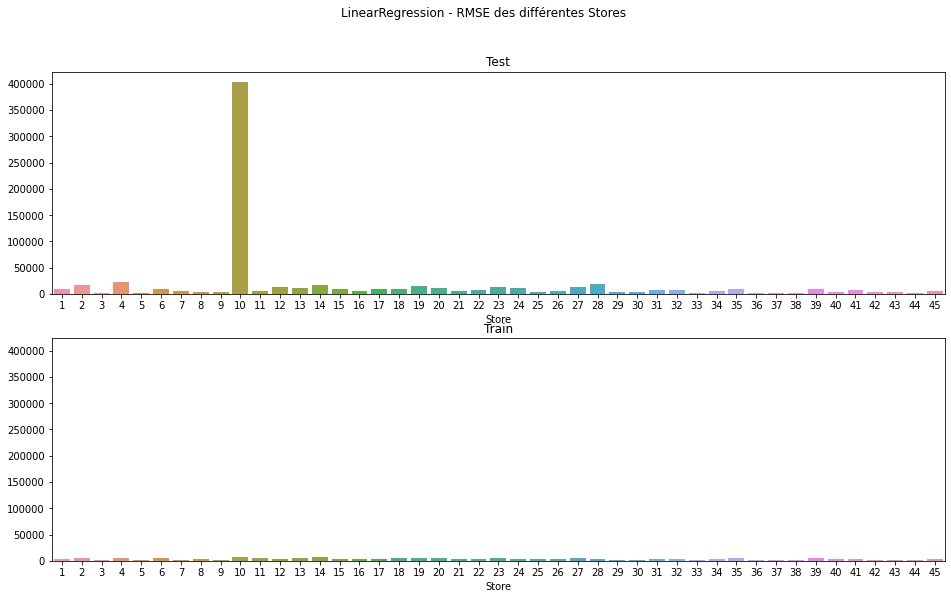

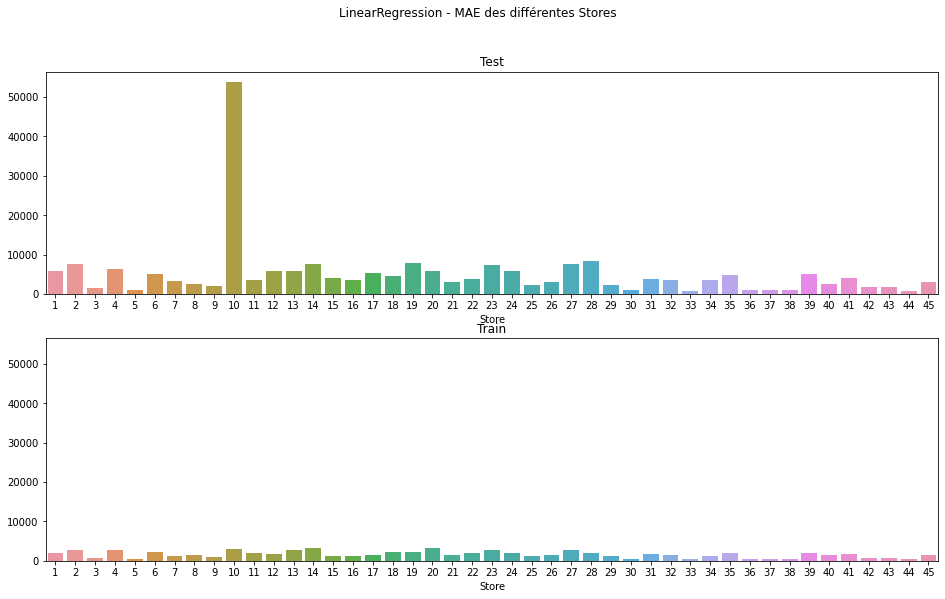

In [33]:
plot_metrics(metrics_lr, model_lr)

In [34]:
#imp_plot(importance_df_lr, model_lr)

#### 7 - 2 - LGBMRegressor

In [35]:
model_lgbm, d_test_lgbm, d_train_lgbm, importance_df_lgbm, t2_lgbm = model_(
  model = LGBMRegressor())



Succès !
L'opération a duré 240.16 sec


 -------> RMSE
 <--> Train : 3765.56
 <--> Test  : 4268.86


 -------> MAE
 <--> Train : 1114.8
 <--> Test  : 1976.25


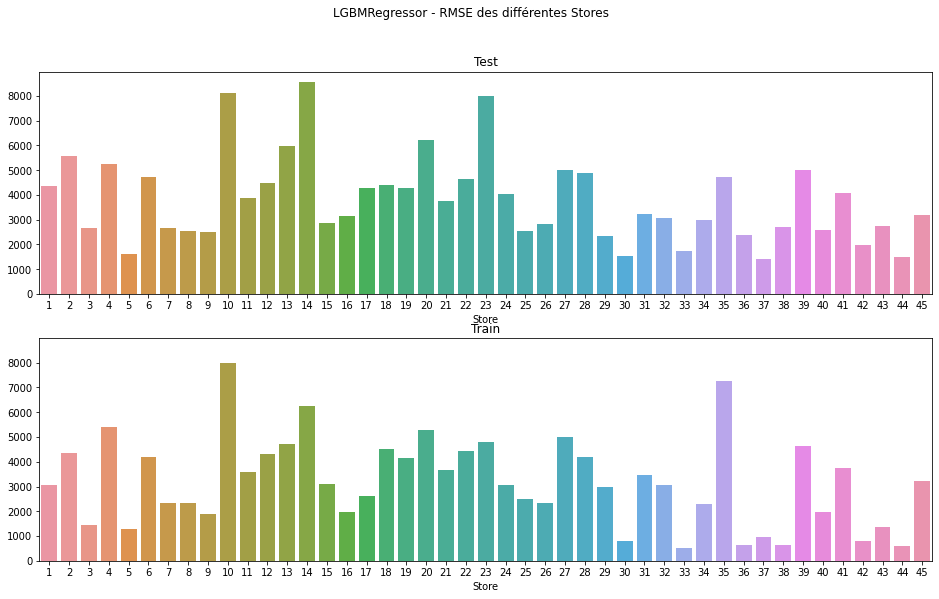

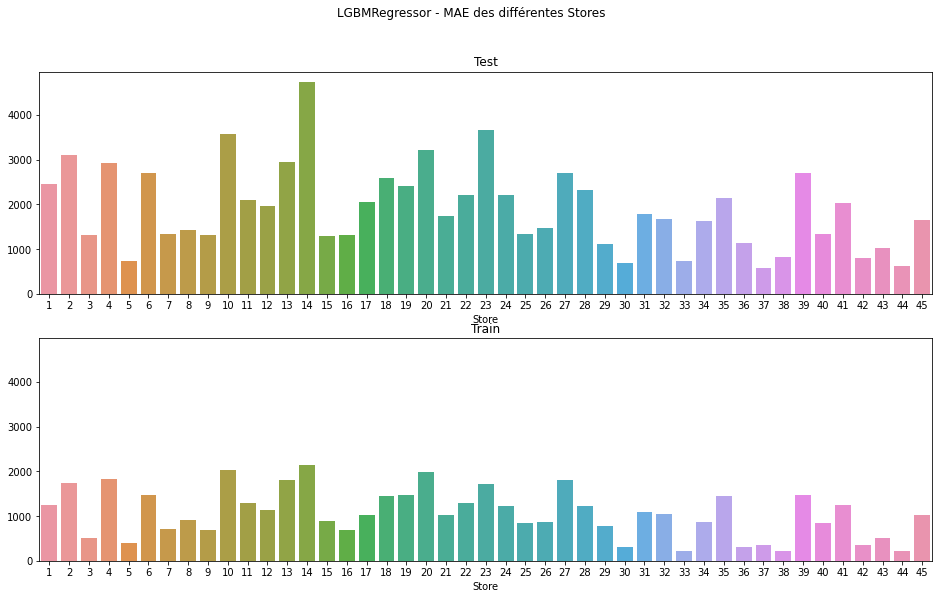

In [36]:
metrics_lgbm = metrics_(d_test_lgbm, d_train_lgbm)
plot_metrics(metrics_lgbm, model_lgbm)

 ---- Features Importance


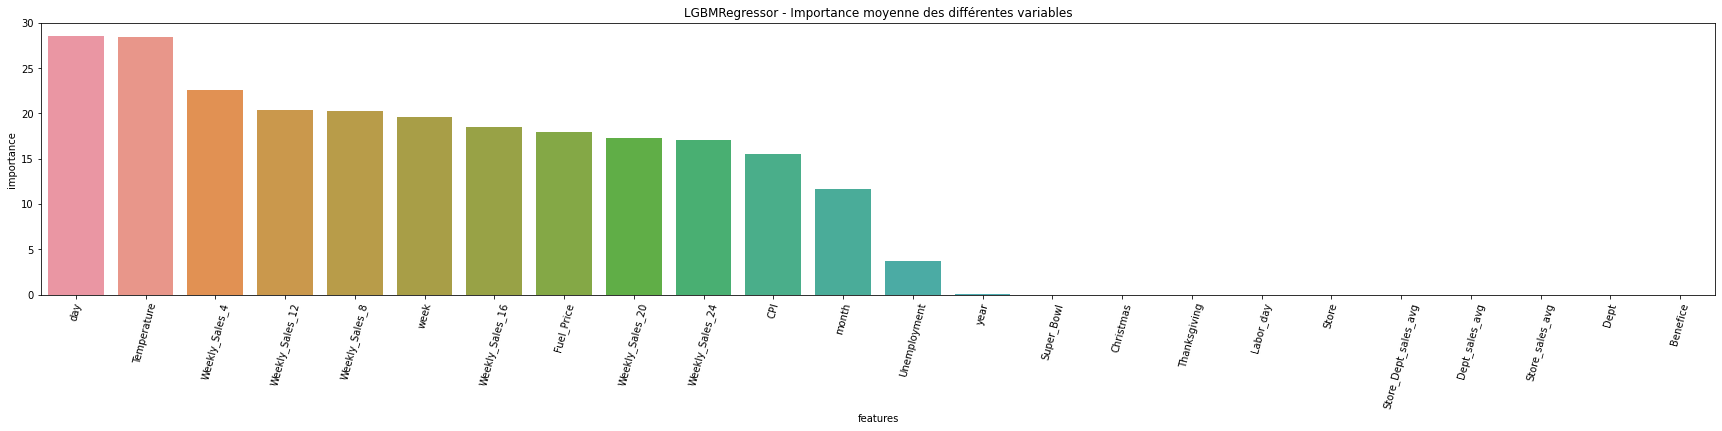

In [37]:
imp_plot(importance_df_lgbm, model_lgbm)

#### 7 - 3 - RandomForestRegressor


In [38]:
model_rf, d_test_rf, d_train_rf,importance_df_rf, t2_rf = model_(
  model = RandomForestRegressor())


Succès !
L'opération a duré 1092.03 sec


 -------> RMSE
 <--> Train : 1743.54
 <--> Test  : 4331.43


 -------> MAE
 <--> Train : 613.64
 <--> Test  : 2069.77


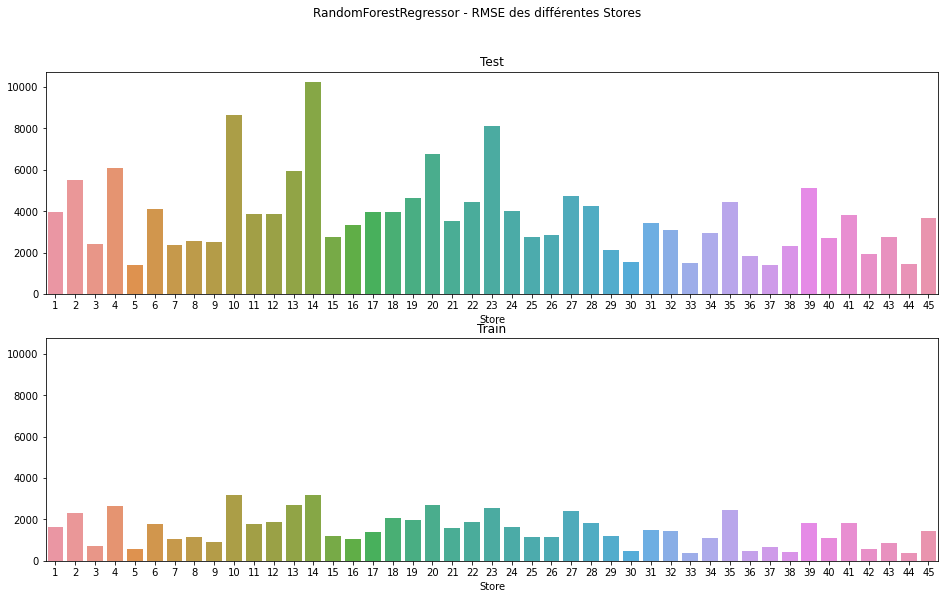

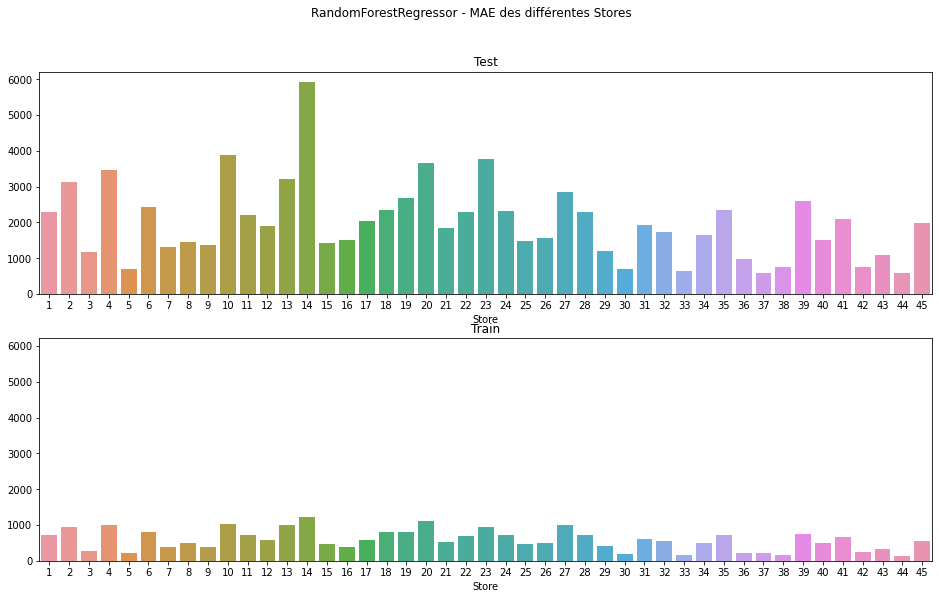

In [39]:
metrics_rf = metrics_(d_test_rf, d_train_rf)
plot_metrics(metrics_rf, model_rf)

 ---- Features Importance


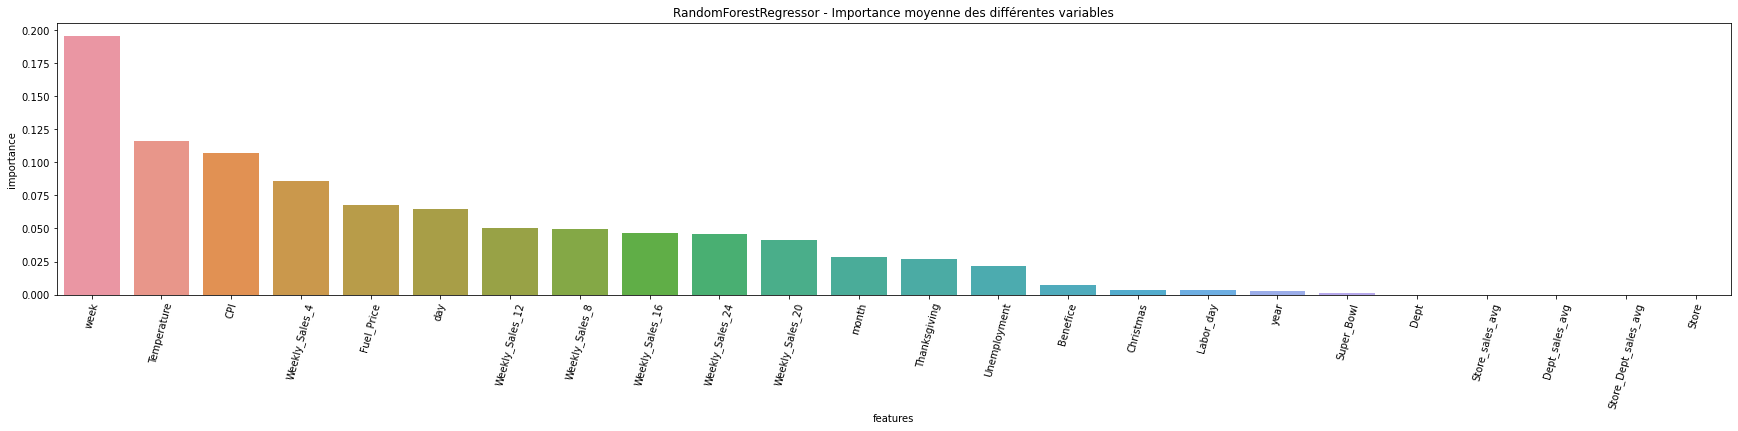

In [40]:
imp_plot(importance_df_rf, model_rf)

#### 7 - 4 - GradientBoostingRegressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb, d_test_gb, d_train_gb,importance_df_gb, t2_gb = model_(
  model = GradientBoostingRegressor())

Succès !
L'opération a duré 400.52 sec


 -------> RMSE
 <--> Train : 430.46
 <--> Test  : 4053.11


 -------> MAE
 <--> Train : 218.53
 <--> Test  : 1877.4


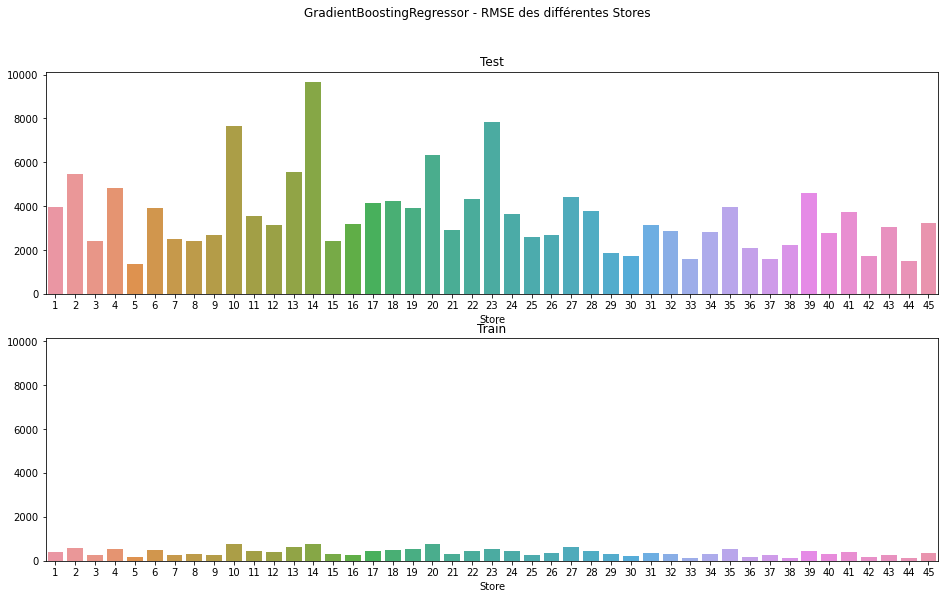

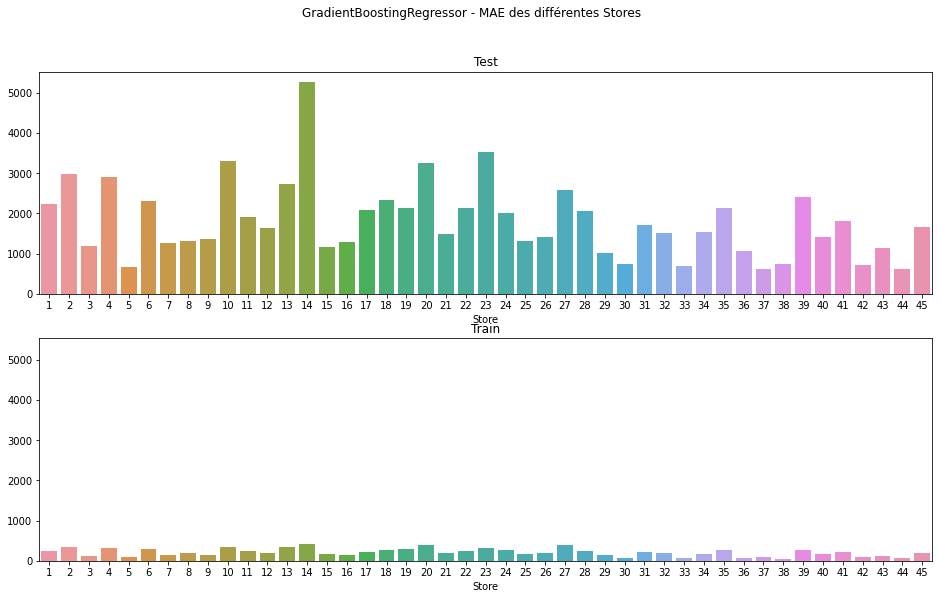

In [42]:
metrics_gb = metrics_(d_test_gb, d_train_gb)
plot_metrics(metrics_gb, model_gb)

 ---- Features Importance


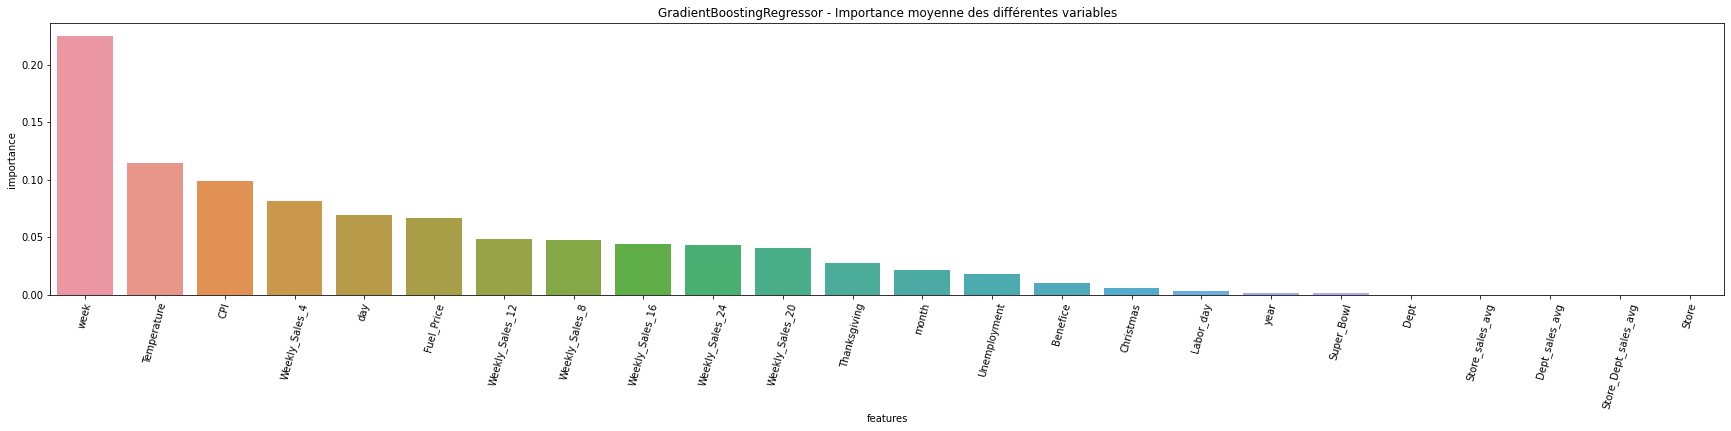

In [43]:
imp_plot(importance_df_gb, model_gb)

#### 7 - 5 - XgBoostRegressor

In [44]:
model_xgb, d_test_xgb, d_train_xgb,importance_df_xgb, t2_xgb = model_(
  model = XGBRegressor(objective="reg:squarederror"))

Succès !
L'opération a duré 209.34 sec


 -------> RMSE
 <--> Train : 611.99
 <--> Test  : 3971.05


 -------> MAE
 <--> Train : 293.35
 <--> Test  : 1842.74


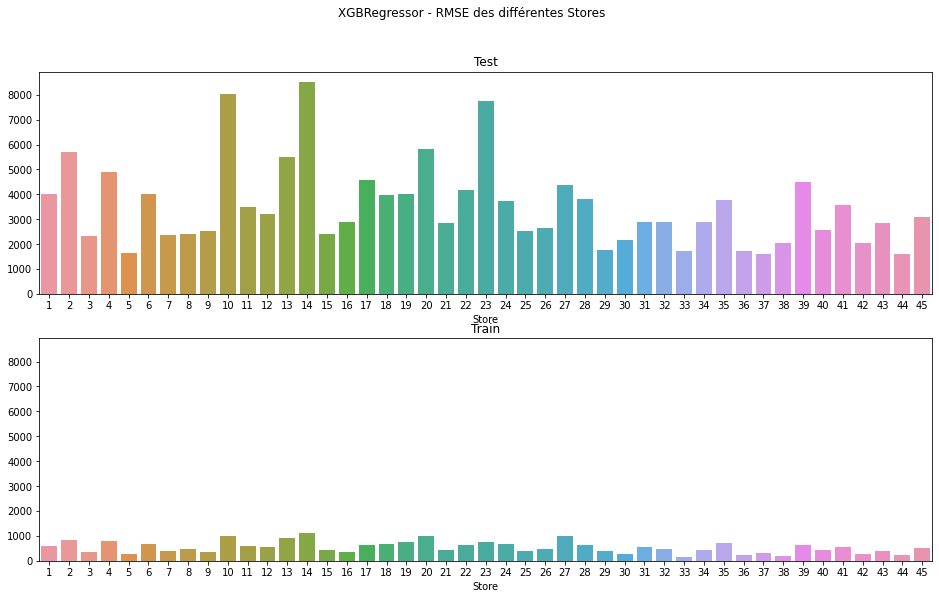

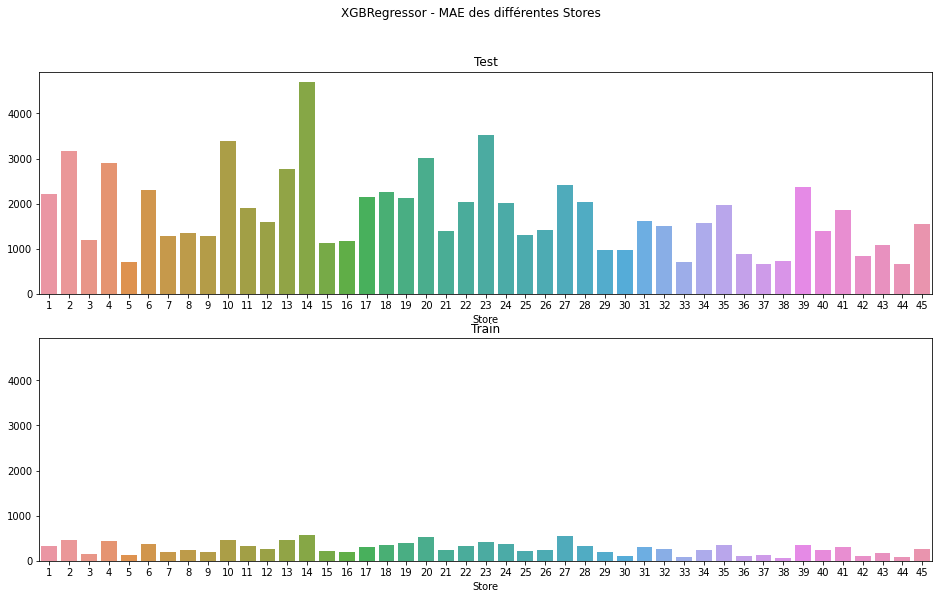

In [45]:
metrics_xgb = metrics_(d_test_xgb, d_train_xgb)
plot_metrics(metrics_xgb, model_xgb)

 ---- Features Importance


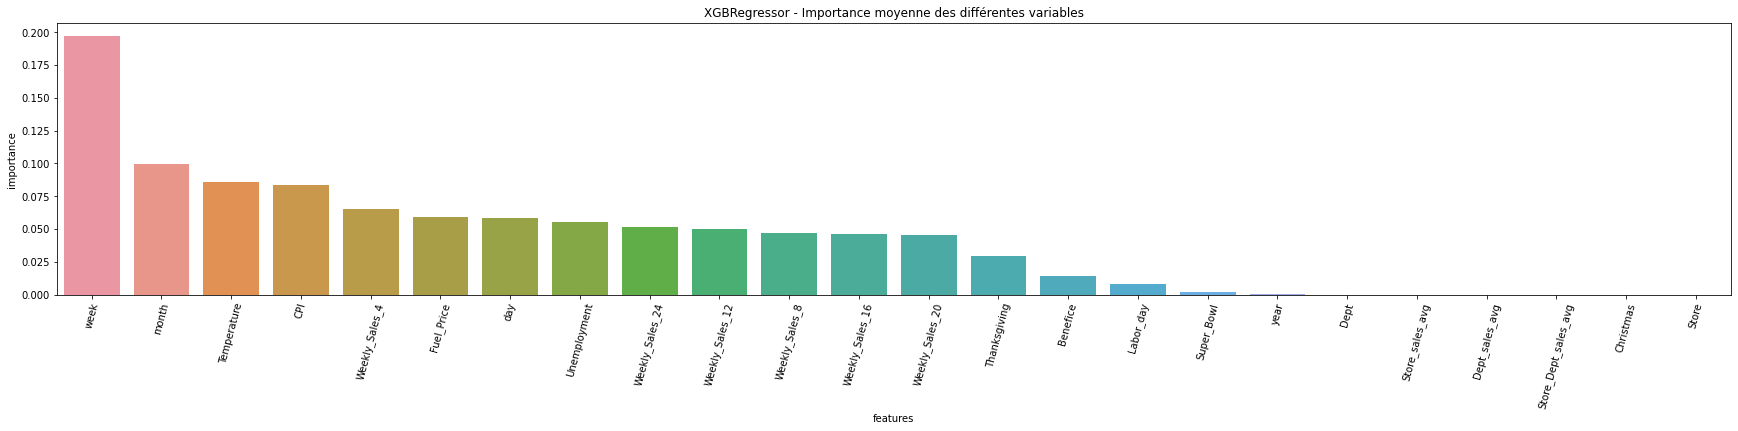

In [46]:
imp_plot(importance_df_xgb, model_xgb)

#### 7 - 6 - VotingRegressor

In [47]:
def voting_(model):

  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()

  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      # Train set
      try:
        train, X_train, y_train, scaler = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass

      # Test set
      try:
        test, X_test, y_test = test_(df__[df__["year"]==2012])
      except:
        pass

      model = model
    
      # Fit the model
      try:
        model.fit(X_train, y_train)
        test_pred = model.predict(X_test)
        pred = pd.DataFrame(test_pred)
        pred = pred.set_index(y_test.index)
        predictions_test = pd.concat([y_test, pred], axis = 1)
        predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
        predictions_test["Store"] = store
        predictions_test["Dept"] = dept
        predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]
        test_pred_train = model.predict(X_train)
        pred_train = pd.DataFrame(test_pred_train)
        pred_train = pred_train.set_index(y_train.index)
        predictions_train = pd.concat([y_train, pred_train], axis = 1)
        predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
        predictions_train["Store"] = store
        predictions_train["Dept"] = dept
        predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

        d_test = pd.concat([d_test, predictions_test], axis = 0)
        d_train = pd.concat([d_train, predictions_train], axis = 0)

      except:
        pass
        

  t2 = time.time() - t1

    #assert d_test.shape[0]  == df[df['year']==2012].shape[0]
    #assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")

  return model, d_test, d_train, t2

In [48]:
from sklearn.ensemble import VotingRegressor
reg1 = GradientBoostingRegressor()
reg2 = RandomForestRegressor()
reg3 = XGBRegressor(objective='reg:squarederror')
reg4 = LGBMRegressor()
vreg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xg', reg3), ('lbgm', reg4)])

model_vr, d_test_vr, d_train_vr, t2_vr = voting_(
  model = vreg)

Succès !
L'opération a duré 1132.91 sec


 -------> RMSE
 <--> Train : 1448.73
 <--> Test  : 3863.88


 -------> MAE
 <--> Train : 518.95
 <--> Test  : 1800.93


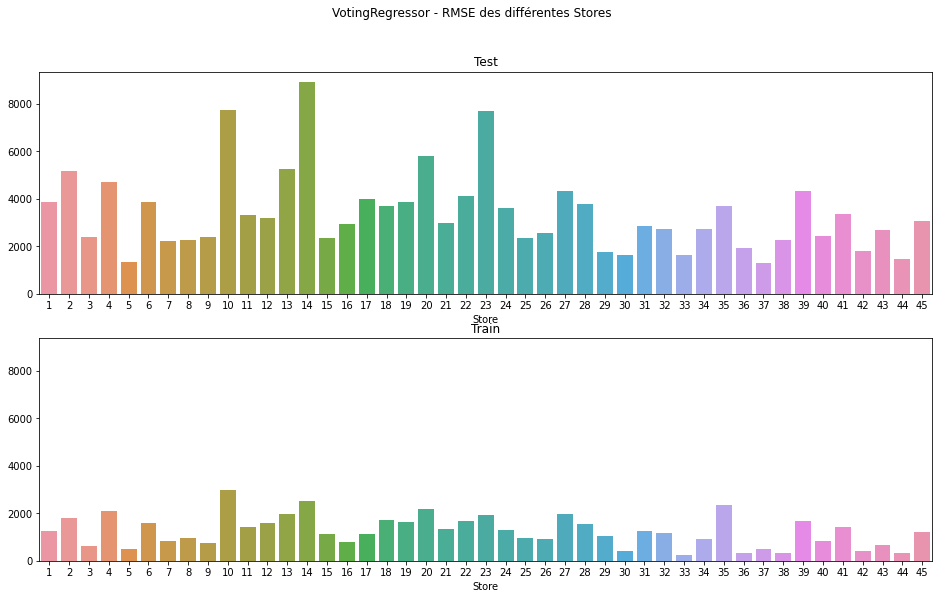

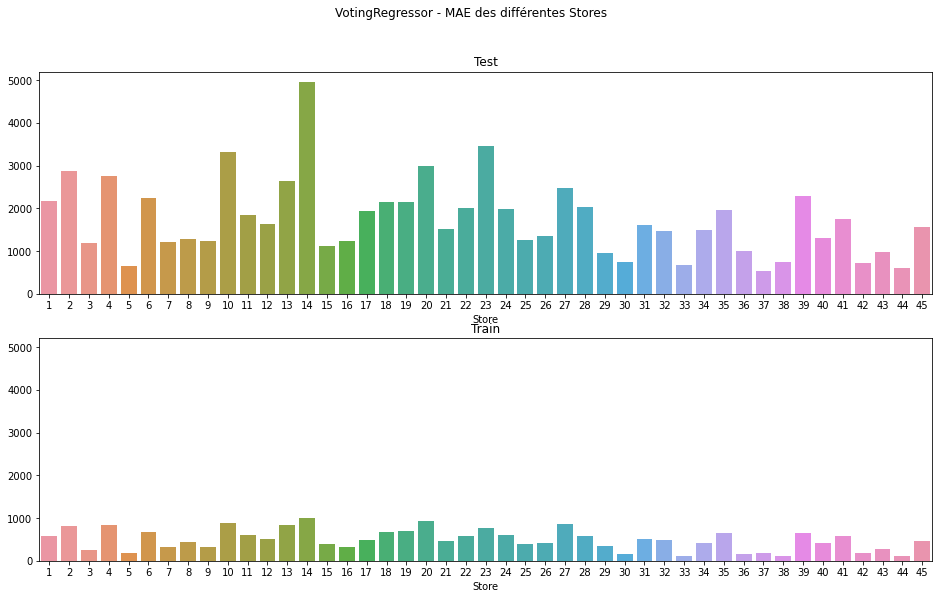

In [49]:
metrics_vr = metrics_(d_test_vr, d_train_vr)
plot_metrics(metrics_vr, model_vr)

#### 7 - 7 - Perfs

In [51]:
perfs = pd.DataFrame(
    
    {"RMSE": [round(np.sqrt(mean_squared_error(d_test_lr["Weekly_Sales"],   d_test_lr['y_pred_test'])),2),    
              round(np.sqrt(mean_squared_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_rf["Weekly_Sales"],   d_test_rf['y_pred_test'])),2), 
              round(np.sqrt(mean_squared_error(d_test_gb["Weekly_Sales"],   d_test_gb['y_pred_test'])),2), 
              round(np.sqrt(mean_squared_error(d_test_xgb["Weekly_Sales"],  d_test_xgb['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_vr["Weekly_Sales"],   d_test_vr['y_pred_test'])),2)], 
    
     "MAE" : [round(mean_absolute_error(d_test_lr["Weekly_Sales"],   d_test_lr['y_pred_test']),2),            
              round(mean_absolute_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test']),2),
              round(mean_absolute_error(d_test_rf["Weekly_Sales"],   d_test_rf['y_pred_test']),2), 
              round(mean_absolute_error(d_test_gb["Weekly_Sales"],   d_test_gb['y_pred_test']),2),
              round(mean_absolute_error(d_test_xgb["Weekly_Sales"],  d_test_xgb['y_pred_test']),2),
              round(mean_absolute_error(d_test_vr["Weekly_Sales"],   d_test_vr['y_pred_test']),2)],

"RMSE_PCT" :[round(100 * np.sqrt(np.mean((d_test_lr["Weekly_Sales"] -   d_test_lr["y_pred_test"]) ** 2))/np.mean(d_test_lr["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_lgbm["Weekly_Sales"] - d_test_lgbm["y_pred_test"]) ** 2))/np.mean(d_test_lgbm["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_rf["Weekly_Sales"] -   d_test_rf["y_pred_test"]) ** 2))/np.mean(d_test_rf["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_gb["Weekly_Sales"] -   d_test_gb["y_pred_test"]) ** 2))/np.mean(d_test_gb["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_xgb["Weekly_Sales"] -  d_test_xgb["y_pred_test"]) ** 2))/np.mean(d_test_xgb["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_rf["Weekly_Sales"] -   d_test_rf["y_pred_test"]) ** 2))/np.mean(d_test_rf["y_pred_test"]), 2)],
     

     "TEMPS(sec)" : [t2_lr, t2_lgbm, t2_rf, t2_gb, t2_xgb, t2_vr]},
    index=["LinearRegression", "LGBMRegressor", "RandomForestRegressor","GradientBoostingRegressor", "XGBRegressor", "VotingRegressor"]
)

In [52]:
perfs.sort_values(by='RMSE')

,RMSE,MAE,RMSE_PCT,TEMPS(sec)
VotingRegressor,3863.88,1800.93,27.23,1132.913249
XGBRegressor,3971.05,1842.74,26.22,209.342927
GradientBoostingRegressor,4053.11,1877.40,26.25,400.521043
LGBMRegressor,4268.86,1976.25,28.11,240.158459
RandomForestRegressor,4331.43,2069.77,27.23,1092.028350
LinearRegression,63295.62,5274.73,470.72,220.673920


In [59]:
perfs.sort_values(by='MAE')

,RMSE,MAE,RMSE_PCT,TEMPS(sec)
VotingRegressor,3863.88,1800.93,27.23,1132.913249
XGBRegressor,3971.05,1842.74,26.22,209.342927
GradientBoostingRegressor,4053.11,1877.40,26.25,400.521043
LGBMRegressor,4268.86,1976.25,28.11,240.158459
RandomForestRegressor,4331.43,2069.77,27.23,1092.028350
LinearRegression,63295.62,5274.73,470.72,220.673920


In [53]:
perfs_train = pd.DataFrame(
    
{"RMSE_TRAIN": 
              [round(np.sqrt(mean_squared_error(d_train_lr["Weekly_Sales"],   d_train_lr['y_pred_train'])),2),    
              round(np.sqrt(mean_squared_error(d_train_lgbm["Weekly_Sales"], d_train_lgbm['y_pred_train'])),2),
              round(np.sqrt(mean_squared_error(d_train_rf["Weekly_Sales"],   d_train_rf['y_pred_train'])),2), 
              round(np.sqrt(mean_squared_error(d_train_gb["Weekly_Sales"],   d_train_gb['y_pred_train'])),2), 
              round(np.sqrt(mean_squared_error(d_train_xgb["Weekly_Sales"],  d_train_xgb['y_pred_train'])),2),
              round(np.sqrt(mean_squared_error(d_train_vr["Weekly_Sales"],   d_train_vr['y_pred_train'])),2)], 
    
"MAE_TRAIN" : 
              [round(mean_absolute_error(d_train_lr["Weekly_Sales"],   d_train_lr['y_pred_train']),2),            
              round(mean_absolute_error(d_train_lgbm["Weekly_Sales"], d_train_lgbm['y_pred_train']),2),
              round(mean_absolute_error(d_train_rf["Weekly_Sales"],   d_train_rf['y_pred_train']),2), 
              round(mean_absolute_error(d_train_gb["Weekly_Sales"],   d_train_gb['y_pred_train']),2),
              round(mean_absolute_error(d_train_xgb["Weekly_Sales"],  d_train_xgb['y_pred_train']),2),
              round(mean_absolute_error(d_train_vr["Weekly_Sales"],   d_train_vr['y_pred_train']),2)],

"RMSE_PCT_TRAIN" :
            [round(100 * np.sqrt(np.mean((d_train_lr["Weekly_Sales"] -   d_train_lr["y_pred_train"]) ** 2))/np.mean(d_train_lr["y_pred_train"]), 2),
             round(100 * np.sqrt(np.mean((d_train_lgbm["Weekly_Sales"] - d_train_lgbm["y_pred_train"]) ** 2))/np.mean(d_train_lgbm["y_pred_train"]), 2),
             round(100 * np.sqrt(np.mean((d_train_rf["Weekly_Sales"] -   d_train_rf["y_pred_train"]) ** 2))/np.mean(d_train_rf["y_pred_train"]), 2),
             round(100 * np.sqrt(np.mean((d_train_gb["Weekly_Sales"] -   d_train_gb["y_pred_train"]) ** 2))/np.mean(d_train_gb["y_pred_train"]), 2),
             round(100 * np.sqrt(np.mean((d_train_xgb["Weekly_Sales"] -  d_train_xgb["y_pred_train"]) ** 2))/np.mean(d_train_xgb["y_pred_train"]), 2),
             round(100 * np.sqrt(np.mean((d_train_rf["Weekly_Sales"] -   d_train_rf["y_pred_train"]) ** 2))/np.mean(d_train_rf["y_pred_train"]), 2)],
     

     "TEMPS(sec)" : [t2_lr, t2_lgbm, t2_rf, t2_gb, t2_xgb, t2_vr]},
    index=["LinearRegression", "LGBMRegressor", "RandomForestRegressor","GradientBoostingRegressor", "XGBRegressor", "VotingRegressor"]
)

In [55]:
perfs_train.sort_values(by='RMSE_TRAIN')

,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,TEMPS(sec)
GradientBoostingRegressor,430.46,218.53,2.67,400.521043
XGBRegressor,611.99,293.35,3.80,209.342927
VotingRegressor,1448.73,518.95,10.83,1132.913249
RandomForestRegressor,1743.54,613.64,10.83,1092.028350
LGBMRegressor,3765.56,1114.80,23.39,240.158459
LinearRegression,4044.54,1704.37,25.12,220.673920


In [60]:
perfs_train.sort_values(by='MAE_TRAIN')

,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,TEMPS(sec)
GradientBoostingRegressor,430.46,218.53,2.67,400.521043
XGBRegressor,611.99,293.35,3.80,209.342927
VotingRegressor,1448.73,518.95,10.83,1132.913249
RandomForestRegressor,1743.54,613.64,10.83,1092.028350
LGBMRegressor,3765.56,1114.80,23.39,240.158459
LinearRegression,4044.54,1704.37,25.12,220.673920


# 8 - Selection de variables

In [56]:
from sklearn.linear_model import Ridge, Lasso, LassoLarsIC, ElasticNet

In [61]:
def reg_pen(estimateur):

  """
  Cette fonction a pour but d'entrainer les modèles de régularisation
  afin de choisir nos prédicteurs.

  params
  ----
  estimateur : Le modèle de régularisation

  returns
  ----
  A : Le dataFrame avec les variables non supprimées

  """

  a = pd.DataFrame()
        # POUR ÉVITER DE DIVISER PAR 0 EN FAISANT LE np.log10
  EPSILON = 1e-4

  importance_df = pd.DataFrame()
  stores = df.Store.unique()

  t1 = time.time()
  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      try:
        train, X_train, y_train, scaler = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass


      # Train and validate
      model = estimateur
      xxx, yyy = X_train, y_train
      model.fit(xxx, yyy)
      a["R2_Store_"+str(store)] = model.score(xxx, yyy)

      a["features"] = [ col for col in xxx.columns if col != "Weekly_Sales"]
      a["coefs_"+str(store)] = model.coef_
  
    a["coefs"]  = np.mean(a[[col for col in a.columns if col.startswith("coefs")]], axis = 1)
    a["R2"]     = np.mean(a[[col for col in a.columns if col.startswith("R2")]], axis = 1)

  a = a[["features", "coefs", "R2"]]
  a = a.sort_values(by = "coefs", ascending = True)
  print("Le", model, "a sélectionné " + str(a[a["coefs"]!=0].shape[0]) + " variables et en a éliminé " +  str(a[a["coefs"]==0].shape[0]))
  print("R2 : "+str(round(np.mean(a['R2']), 2)))
  vars = list(a[a["coefs"]!=0]["features"])
  print("Les variables sélectionnées sont : \n"+ str(vars))
  print("Les variables supprimées sont : \n"+ str(list(a[a["coefs"]==0]["features"])))
  return a


In [62]:
ridge = reg_pen(Ridge())

Le Ridge() a sélectionné 16 variables et en a éliminé 8
R2 : 0.93
Les variables sélectionnées sont : 
['month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Christmas', 'Unemployment', 'Weekly_Sales_12', 'Benefice', 'Weekly_Sales_20', 'Temperature', 'Weekly_Sales_24', 'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving']
Les variables supprimées sont : 
['Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'Store_sales_avg', 'Store', 'year', 'Dept']


In [63]:
lasso = reg_pen(Lasso())

Le Lasso() a sélectionné 15 variables et en a éliminé 9
R2 : 0.91
Les variables sélectionnées sont : 
['month', 'Weekly_Sales_12', 'week', 'Benefice', 'Unemployment', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Thanksgiving', 'CPI', 'Fuel_Price', 'Weekly_Sales_20', 'Weekly_Sales_16', 'day', 'Weekly_Sales_24', 'Temperature']
Les variables supprimées sont : 
['Store', 'Dept', 'Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'year', 'Store_sales_avg', 'Christmas']


In [64]:
elnet = reg_pen(ElasticNet())

Le ElasticNet() a sélectionné 16 variables et en a éliminé 8
R2 : 0.85
Les variables sélectionnées sont : 
['month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Christmas', 'Unemployment', 'Benefice', 'Weekly_Sales_12', 'Weekly_Sales_20', 'Weekly_Sales_24', 'Temperature', 'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving']
Les variables supprimées sont : 
['Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'Store_sales_avg', 'Store', 'year', 'Dept']


on va suivre les recommandations du Ridge

In [126]:
df_ = df[['month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 
          'Christmas', 'Unemployment', 'Weekly_Sales_12', 'Benefice', 
          'Weekly_Sales_20', 'Temperature', 'Weekly_Sales_24', 
          'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving','Store', "Dept"]]

In [127]:
df_.head()

,month,week,CPI,Weekly_Sales_4,Weekly_Sales_8,Christmas,Unemployment,Weekly_Sales_12,Benefice,Weekly_Sales_20,Temperature,Weekly_Sales_24,Weekly_Sales_16,Fuel_Price,day,Thanksgiving,Store,Dept
Date,,,,,,,,,,,,,,,,,,
2010-02-05,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0,1,1
2010-02-05,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0,1,2
2010-02-05,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0,1,3
2010-02-05,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0,1,4
2010-02-05,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0,1,5



# 9 - Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction - Expanding Windows

On va faire des expanding windows de 6 mois chaque fois.
Mais avant il faudrait que l'on connaisse les index pour faire les splits.

In [ ]:
[
 df[(df["year"]==2010) & (df["month"]==2)].index[0], df[(df["year"]==2010) & (df["month"]==6)].index[-1], df[(df["year"]==2010) & (df["month"]==7)].index[0], df[(df["year"]==2010) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2011) & (df["month"]==1)].index[0], df[(df["year"]==2011) & (df["month"]==6)].index[-1], df[(df["year"]==2011) & (df["month"]==7)].index[0], df[(df["year"]==2011) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2012) & (df["month"]==1)].index[0], df[(df["year"]==2012) & (df["month"]==6)].index[-1], df[(df["year"]==2012) & (df["month"]==7)].index[0], df[(df["year"]==2012) & (df["month"]==10)].index[-1], 
 
 ]

[Timestamp('2010-02-05 00:00:00'),
 Timestamp('2010-06-25 00:00:00'),
 Timestamp('2010-07-02 00:00:00'),
 Timestamp('2010-12-31 00:00:00'),
 Timestamp('2011-01-07 00:00:00'),
 Timestamp('2011-06-24 00:00:00'),
 Timestamp('2011-07-01 00:00:00'),
 Timestamp('2011-12-30 00:00:00'),
 Timestamp('2012-01-06 00:00:00'),
 Timestamp('2012-06-29 00:00:00'),
 Timestamp('2012-07-06 00:00:00'),
 Timestamp('2012-10-26 00:00:00')]

In [87]:

# WINDOW 1
train_1 = df_.loc['2010-02-05':'2010-12-31'] # 1 an (année 2010)
test_1  = df_.loc['2011-01-07':'2011-06-24'] # 6 mois (Janv à Juin 2011)

# WINDOW 2
train_2 = df_.loc['2010-02-05':'2011-06-24'] # 1 an et 6 mois (Debut 2010 à Juin 2011)
test_2  = df_.loc['2011-07-01':'2011-12-30'] # 6 mois (Juillet à Décembre 2011)

# WINDOW 3
train_3 = df_.loc['2010-02-05':'2011-12-30'] # 2 ans (Début 2010 à Fin 2011)
test_3  = df_.loc['2012-01-06':'2012-06-29'] # 6 mois (Janv à Juin 2012)

# WINDOW 4
train_4 = df_.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois (Début 2010 à Juin 2012)
test_4  = df_.loc['2012-07-06':'2012-10-26'] # 6 mois (Juillet 2012 à Déc 2012)

In [95]:
def metrics_np(predictions_test, predictions_train):
  

  """
  Cette fonction permet de calculer les métriques de notre modèle.

  params
  ----
  predictions_test, predictions_train : Les predictions dans le test et train

  returns
  ----
  metrics : Les métriques du modèle
  
  """
  
  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)

  return metrics


In [131]:
def exp_win(model, exp_window):

  #print("--> Expanding window : ", exp_window, "<--")


  """
  Cette fonction a pour but d'entrainer les modèles de Machine Learning
  pour chaque Window

  params
  ----
  model : Le modèle de Machine Learning
  exp_window : La fenêtre d'entrainement

  returns
  ----
  model : Le modèle de Machine Learning entrainé
  d_test, d_train : Les prédictions dans le test et train set
  t2 : Le temps d’exécution 
  """
  

  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()
  for store in stores:
    df_ = df[df['Store']==store]
    depts = df_.Dept.unique()
    for dept in depts:
      df__ = df_[df_["Dept"]==dept]

      if exp_window   == 1:
        try:
          train, X_train, y_train, scaler = train_(df__[df__.index.isin(['2010-02-05','2010-12-31'])])
          test, X_test, y_test = test_(df__[df__.index.isin(['2010-02-05','2010-12-31'])])
        except:
          pass

      if exp_window   == 2:
        try:
          train, X_train, y_train, scaler = train_(df__[df__.index.isin(['2010-02-05','2011-06-24'])])
          test, X_test, y_test = test_(df__[df__.index.isin(['2011-07-01','2011-12-30'])])
        except:
          pass

      if exp_window   == 3:
        try:
          train, X_train, y_train, scaler = train_(df__[df__.index.isin(['2012-01-06','2012-06-29'])])
          test, X_test, y_test = test_(df__[df__.index.isin(['2010-02-05','2010-12-31'])])
        except:
          pass


      if exp_window   == 4:
        try:
          train, X_train, y_train, scaler = train_(df__[df__.index.isin(['2010-02-05','2012-06-29'])])
          test, X_test, y_test = test_(df__[df__.index.isin(['2012-07-06','2012-10-26'])])
        except:
          pass

      
      # Train and validate
      model = model

      # Fit model
      model.fit(X_train, y_train)

      test_pred = model.predict(X_test)
      pred = pd.DataFrame(test_pred)
      pred = pred.set_index(y_test.index)
      predictions_test = pd.concat([y_test, pred], axis = 1)
      predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
      predictions_test["Store"] = store
      #predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

      test_pred_train = model.predict(X_train)
      pred_train = pd.DataFrame(test_pred_train)
      pred_train = pred_train.set_index(y_train.index)
      predictions_train = pd.concat([y_train, pred_train], axis = 1)
      predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
      predictions_train["Store"] = store
      #predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

      d_test = pd.concat([d_test, predictions_test], axis = 0)
      d_train = pd.concat([d_train, predictions_train], axis = 0)



    t2 = time.time() - t1


    metrics = metrics_np(d_test, d_train)
    t2 = time.time() - t1
  
  return t2, model, exp_window, d_test, d_train

In [122]:
def expand_all_windows(model):
  
  a ={
      
      "RMSE"             : [], 
      "RMSE_TRAIN"       : [],

      "MAE"              : [],
      "MAE_TRAIN"        : [],

      "RMSE_PCT"         : [],
      "RMSE_PCT_TRAIN"   : [],
      
      "WIND"             : [],
      "MODEL"            : [],
      "TEMPS(sec)"       : []
      
      }

  t3 = time.time()
  for i in range(1,5):
    t2, model, exp_window, d_test, d_train = exp_win(model, i)

    # TEST
    a["RMSE"].append(round(np.sqrt(mean_squared_error(d_test["Weekly_Sales"], d_test['y_pred_test'])),2))
    a["MAE"].append(round(mean_absolute_error(d_test["Weekly_Sales"], d_test['y_pred_test']),2))
    a["RMSE_PCT"].append(round(100*np.sqrt(np.mean((d_test["Weekly_Sales"] - d_test["y_pred_test"]) ** 2))/np.mean(d_test["y_pred_test"]),2))

    # TRAIN
    a["RMSE_TRAIN"].append(round(np.sqrt(mean_squared_error(d_train["Weekly_Sales"], d_train['y_pred_train'])),2))
    a["MAE_TRAIN"].append(round(mean_absolute_error(d_train["Weekly_Sales"], d_train['y_pred_train']),2))
    a["RMSE_PCT_TRAIN"].append(round(100*np.sqrt(np.mean((d_train["Weekly_Sales"] - d_train["y_pred_train"]) ** 2))/np.mean(d_train["y_pred_train"]),2))

    a["WIND"].append(exp_window)
    a["MODEL"].append(str(re.findall(r"\w+", str(model))[0]))
    a["TEMPS(sec)"].append(round(t2,2))

  data = pd.DataFrame(a)
  t4 = time.time() - t3

  print("Succès !")

  if t4 > 200:
    print("L'opération a duré environ "+str(int(t4/60))+" min")

  else:

    print("L'opération a duré "+str(round(t4, 2))+" sec")

  return data


#### 9 - 1 - XGBRegressor

In [ ]:
xgb = expand_all_windows(XGBRegressor())

In [125]:
xgb.head()

,RMSE,RMSE_TRAIN,MAE,MAE_TRAIN,RMSE_PCT,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,122.32,122.32,57.58,57.58,0.85,0.85,1,XGBRegressor,156.36
1,7060.54,119.46,3071.98,56.84,47.62,0.77,2,XGBRegressor,130.41
2,8064.19,104.90,3736.68,51.18,56.40,0.72,3,XGBRegressor,105.70
3,6007.33,121.97,2727.71,58.96,41.07,0.78,4,XGBRegressor,116.86


#### 9 - 2 - LGBMRegressor

In [ ]:
lgbm = expand_all_windows(LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1
       ))

In [ ]:
lgbm.head()

#### 9 - 3 - RandomForestRegressor

In [ ]:
rf =  expand_all_windows(RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                               max_features='auto'))

In [ ]:
rf.head()

#### 9 - 4 - LinearRegression

In [ ]:
lr =  expand_all_windows(LinearRegression()) 

In [ ]:
lr.head()

#### 9 - 5 - GradientBoostingRegressor

In [ ]:
gb =  expand_all_windows(GradientBoostingRegressor()) 

In [ ]:
gb.head()

#### 9 - 6 - VotingRegressor

In [ ]:
vo_reg =  expand_all_windows(vreg()) 

In [ ]:
vo_reg.head()

# 10 - Discussion autour de la performance des modèles

In [ ]:
performances = pd.concat([rf, xgb, lgbm, lr, gb, vo_reg], axis = 0)

In [ ]:
perf_per_rmse = performances.sort_values(by = "RMSE", ascending = True)

perf_per_rmse.head(20)

In [ ]:
pprmse = perf_per_rmse.iloc[:3, :]

In [ ]:
sns.barplot(x=pprmse["MODEL"], y=pprmse["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()
print("\n")
sns.barplot(x=pprmse["MODEL"], y=pprmse["TEMPS(sec)"].values)
plt.title("Classement par TEMPS")
plt.show()

In [ ]:
perf_per_mae = performances.sort_values(by = ["MAE"], ascending = True)

perf_per_mae.head(20)

Les perfs dans le test, en prenant en compte MAE et RMSE ne changent pas l'ordre de qualité des modèles. Le meilleur modèle niveau performance est le catboost suivi du RandomForest et du Lgbm. Toutefois par soucis de ressources computationnelles, on va préférer le lgbm qui consomme moins de temps à fournir les estimations.

La 2e remarque est que globalement, les pires performances des modèles sont lorsque ces derniers ont moins de données historiques (WIND = 1), et que généralement plus la taille du train set augmente plus les performances s'améliorent.

Et si on comparait avec notre Benchmark ?

In [ ]:
ppbench = perfs.iloc[1:, :].sort_values(by = ["RMSE"], ascending = True)

ppbench = ppbench.reset_index()

ppbench.columns = ['MODEL', 'RMSE', 'MAE', 'RMSE_PCT', 'TEMPS(sec)']

ppbench

In [ ]:
plt.figure(figsize = (8, 5))
sns.barplot(x = ppbench["MODEL"], y = ppbench["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()

On fait nettement mieux que le Benchmark, les RMSE y sont plus élevées.




In [ ]:
imp_plot(importance_df_lgbm, model_lgbm)